# Import Dependencies

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential 
import tensorflow as tf

from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input, Dense
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import pickle 

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from math import dist
import numpy as np
from geopy.distance import geodesic
from haversine import haversine

/Users/adamgrunwald/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:




def haversine_dist(x1,x2,y1,y2):
   return haversine((x1, x2) , (y1, y2), unit='km')

# Data Processing 



def extract_features_from_longitude_latitude(df, home_longitude, home_latitude):
    home_coords = (home_latitude, home_longitude)

    df['distance_from_home'] = np.vectorize(haversine_dist)(df['mean_latitude'],df['mean_longitude'],home_latitude,home_longitude)

    df['heading_to_home'] = np.arctan2(df['mean_latitude'] - home_latitude, df['mean_longitude'] - home_longitude)
    df['heading_to_home_sin'] = np.sin(df['heading_to_home'])
    df['heading_to_home_cos'] = np.cos(df['heading_to_home'])
    # resample by 10m mean
    df['time_stamp'] = df.index
    # calculate the speed of device
    df['time_diff'] = df['time_stamp'].diff().dt.total_seconds() / 3600  # Convert seconds to hours
    df['distance'] = np.vectorize(haversine_dist)(df['mean_latitude'],df['mean_longitude'],df['mean_latitude'].shift(1),df['mean_longitude'].shift(1)) #calculate haversine distance
    # df['hours'] = (df['time_stamp'].astype(int) / 10**9) / 60*60 # convert to seconds
    # df['time_taken'] = df['hours'] - df['hours'].shift(1) # calculate time difference

    df['speed'] = df['distance']/df['time_diff'] # cal speed
    df.loc[df['speed'] > 200, 'speed'] = 0
    df['speed_towards_home'] = df['speed'] * df['heading_to_home_cos']
    return df

# df = df.resample('10T').mean()


In [3]:
from influxdb import DataFrameClient
import pandas as pd
db_name_zuka = 'smart_home_zukalovi'
dataframe_client_zuka = DataFrameClient(
            host='localhost',
            port=8086,
            username='root',
            password='root',
            database='smart_home_zukalovi',
        )

left_time_interval = pd.to_datetime('2023-10-01 00:00:00')
right_time_interval = pd.to_datetime('2024-3-16 15:00:00')
left_time_interval = f"'{left_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
right_time_interval = f"'{right_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
group_by_time_interval = '10s'
tmp_output_water_entity_id_zuka = 'esphome_web_c771e8_ntc_temperature_b_constant'
tmp_output_water_entity_id_2_zuka = 'esphome_web_c771e8_ntc_temperature_b_constant_2'
tmp_boiler_case_entity_id_zuka = 'esphome_web_c771e8_tmp3'
relay_entity_id_zuka = 'shelly1pm_84cca8b07eae'
device_tracker_entity_zuka = 'klara_z_iphone'


In [4]:
dataframe_client_form = DataFrameClient(
            host='localhost',
            port=8086,
            username='root',
            password='root',
            database='smart_home_formankovi',
        )
db_name_form = 'smart_home_formankovi'
tmp_output_water_entity_id_form = 'esphome_boiler_temps_ntc_temperature_b_constant'
tmp_output_water_entity_id_2_form = 'esphome_web_b7a7f1_ntc_temperature_b_constant'
tmp_boiler_case_entity_id_form = 'shelly1pm_34945475a969_temperature_2'
relay_entity_id_form = 'shelly1pm_34945475a969'
device_tracker_entity_form = 'rmx3085'

In [5]:

# format datetime to YYYY-MM-DDTHH:MM:SSZ


def get_queries(db_name, left_time_interval, right_time_interval, group_by_time_interval, tmp_output_water_entity_id, tmp_output_water_entity_id_2, tmp_boiler_case_entity_id, relay_entity_id, device_tracker_entity):

    return {
        "water_flow": {
            "sql_query": f'SELECT mean("value") AS "water_flow_L_per_minute_mean" FROM "{db_name}"."autogen"."L/min" WHERE time > {left_time_interval} AND time < {right_time_interval} GROUP BY time({group_by_time_interval}) FILL(0)',
            "measurement": "L/min",
        },
        "water_temperature": {
            "sql_query": f'SELECT mean("value") AS "water_temperature_mean" FROM "{db_name}"."autogen"."°C" WHERE time > {left_time_interval} AND time < {right_time_interval} AND ("entity_id"=\'{tmp_output_water_entity_id}\' OR "entity_id"=\'{tmp_output_water_entity_id_2}\') GROUP BY time({group_by_time_interval}) FILL(0)',
            "measurement": "°C",
        },
        "temperature": {
            "sql_query": f'SELECT mean("temperature") AS "outside_temperature_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'weather\' AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "humidity": {
            "sql_query": f'SELECT mean("humidity") AS "outside_humidity_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'weather\' AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "wind_speed": {
            "sql_query": f'SELECT mean("wind_speed") AS "outside_wind_speed_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "presence": {
            "sql_query": f'SELECT count(distinct("friendly_name_str")) AS "device_presence_distinct_count" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "state"=\'home\' GROUP BY time({group_by_time_interval}) FILL(0)',
            "measurement": "state",
        },
        "boiler_water_temperature": {
            "sql_query": f'SELECT mean("value") AS "boiler_water_temperature_mean" FROM "{db_name}"."autogen"."°C" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'{tmp_boiler_case_entity_id}\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "°C",
        },
        "boiler_relay_status": {
            "sql_query": f'SELECT last("value") AS "boiler_relay_status" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'{relay_entity_id}\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "device_longitude": {
            "sql_query": f'SELECT mean("longitude") AS "mean_longitude" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "entity_id"=\'{device_tracker_entity}\' GROUP BY time({group_by_time_interval}) FILL(linear)',
            "measurement": "state",
        },
        "device_latitude": {
            "sql_query": f'SELECT mean("latitude") AS "mean_latitude" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "entity_id"=\'{device_tracker_entity}\' GROUP BY time({group_by_time_interval}) FILL(linear)',
            "measurement": "state",
        },
        
    } 

In [6]:
# df_all_list = []

# for key, value in get_queries(db_name = db_name_form, left_time_interval = left_time_interval, right_time_interval = right_time_interval, group_by_time_interval = group_by_time_interval, tmp_output_water_entity_id = tmp_output_water_entity_id_form, tmp_output_water_entity_id_2 = tmp_output_water_entity_id_2_form, tmp_boiler_case_entity_id = tmp_boiler_case_entity_id_form, relay_entity_id = relay_entity_id_form, device_tracker_entity = device_tracker_entity_form).items():
#     print("Querying: ", key, value["sql_query"])
#     # get data from influxdb
#     result = dataframe_client_form.query(value["sql_query"])[
#         value["measurement"]
#     ]

#     df = pd.DataFrame(result)
    
#     df_all_list.append(df)

# df_concat_form = pd.concat(df_all_list, axis=1)
# # save as pkl
# with open('df_form_mult_16032024.pkl', 'wb') as f:
#     df_concat_form.to_pickle(f)

In [7]:
# df_all_list = []
#     # iterate over key an value in data
# for key, value in get_queries(db_name=db_name_zuka, left_time_interval=left_time_interval, right_time_interval=right_time_interval, group_by_time_interval='10s', tmp_output_water_entity_id=tmp_output_water_entity_id_2_zuka, tmp_output_water_entity_id_2=tmp_output_water_entity_id_zuka, tmp_boiler_case_entity_id=tmp_boiler_case_entity_id_zuka, relay_entity_id=relay_entity_id_zuka, device_tracker_entity=device_tracker_entity_zuka).items():
#     print("Querying: ", key, value["sql_query"])
#     # get data from influxdb
#     result = dataframe_client_zuka.query(value["sql_query"])[
#         value["measurement"]
#     ]

#     df = pd.DataFrame(result)
    
#     df_all_list.append(df)

# df_concat_zuka = pd.concat(df_all_list, axis=1)
# # save as pkl
# with open('df_zuka_mult_16032024.pkl', 'wb') as f:
#     df_concat_zuka.to_pickle(f)

In [8]:
with open('df_zuka_mult_16032024.pkl', 'rb') as f:
    df_concat_zuka = pickle.load(f)
    df_concat_zuka = df_concat_zuka.dropna(subset=['water_temperature_mean'])
    

#49.412897925874184, 16.514843458109933
zuka_home_longitude = 16.514843458109933
zuka_home_latitude = 49.412897925874184
df_copy_zuka = df_concat_zuka.copy()
df_extracted_zuka = extract_features_from_longitude_latitude(df_copy_zuka, home_longitude=zuka_home_longitude, home_latitude=zuka_home_latitude)
# all value in speed larger than 200 set to 0
df_extracted_zuka.loc[df_extracted_zuka['speed'] > 200, 'speed'] = 0

In [9]:
#load df form pkl
with open('df_form_mult_16032024.pkl', 'rb') as f:
    df_concat_form = pickle.load(f)
    df_concat_form = df_concat_form.dropna(subset=['water_temperature_mean'])

    
    

# 49.39534649920643, 16.527887919743097
form_home_longitude = 16.527887919743097
form_home_latitude = 49.39534649920643

df_copy_form = df_concat_form.copy()
df_extracted_form = extract_features_from_longitude_latitude(df_copy_form, home_longitude=form_home_longitude, home_latitude=form_home_latitude)
# all value in speed larger than 200 set to 0
df_extracted_form.loc[df_extracted_form['speed'] > 200, 'speed'] = 0

In [10]:
from data_handler import DataHandler

Importing /Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py


In [11]:
left_time_interval = pd.to_datetime("2023-10-01 00:00:00")
right_time_interval = pd.to_datetime("2024-3-16 15:00:00")
left_time_interval = f"'{left_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
right_time_interval = f"'{right_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
group_by_time_interval = "10s"
tmp_output_water_entity_id_zuka = "esphome_web_c771e8_ntc_temperature_b_constant"
tmp_output_water_entity_id_2_zuka = "esphome_web_c771e8_ntc_temperature_b_constant_2"
tmp_boiler_case_entity_id_zuka = "esphome_web_c771e8_tmp3"
relay_entity_id_zuka = "shelly1pm_84cca8b07eae"
relay_power_entity_id_zuka = "shelly1pm_84cca8b07eae_power"
device_tracker_entity_zuka = "klara_z_iphone"

dataHandler = DataHandler(
    "localhost", "smart_home_zukalovi", "root", "root", relay_entity_id_zuka, relay_power_entity_id_zuka, tmp_boiler_case_entity_id_zuka, tmp_output_water_entity_id_zuka, tmp_output_water_entity_id_2_zuka, device_tracker_entity_zuka, zuka_home_longitude, zuka_home_latitude
)
# dataHandlerForm = DataHandler(
#     "localhost", "smart_home_formankovi", "root", "root", relay_entity_id_form, relay_power_entity_id_form, tmp_boiler_case_entity_id_form, tmp_output_water_entity_id_form, tmp_output_water_entity_id_2_form, device_tracker_entity_form, form_home_longitude, form_home_latitude
# )

In [12]:

data_processed_zuka = dataHandler.process_kWh_water_consumption(df_extracted_zuka)
data_processed_zuka_ml = dataHandler.transform_data_for_ml(data_processed_zuka)
ml_data_zuka = data_processed_zuka_ml[0]


In [13]:
# data_processed_form = dataHandler.process_kWh_water_consumption(df_extracted_form)
# data_processed_form_ml = dataHandler.transform_data_for_ml(data_processed_form)
# ml_data_form = data_processed_form_ml[0]




<AxesSubplot:>

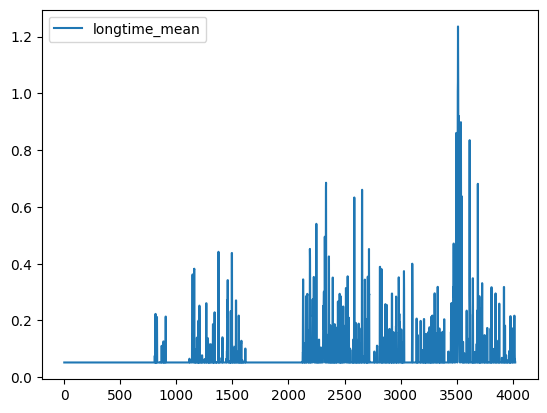

In [14]:
ml_data_zuka.plot(y='longtime_mean')

In [15]:
df = ml_data_zuka.reset_index(drop=True)

# #10T
df_10T = pd.concat([df.iloc[7000:9000], df.iloc[12500:]])
with open('df_10T.pkl', 'wb') as f:
    df_10T.to_pickle(f)

# 30T

df_30T = pd.concat([df.iloc[2333:3100], df.iloc[4166:]])
with open('df_30T.pkl', 'wb') as f:
    df_30T.to_pickle(f)

#60T
df_60T = pd.concat([df.iloc[1166:1550], df.iloc[2083:]])
with open('df_60T.pkl', 'wb') as f:
    df_60T.to_pickle(f)

df = df_60T.reset_index(drop=True).dropna()
df_train = df.loc[:int(df.shape[0]*0.8),:]
df_test = df.loc[int(df.shape[0]*0.8):,:]



<AxesSubplot:>

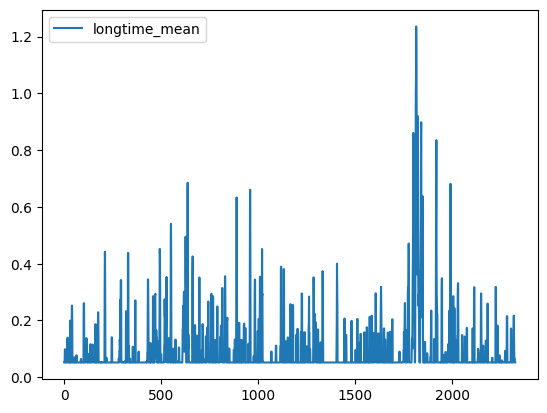

In [16]:
df.plot(y='longtime_mean')



## Normalize the Data
- for available scalers see: http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
- becareful of outliers when scaling!
- perform the normalization on the pandas dataframe

In [17]:
from sklearn.preprocessing import RobustScaler




## Use a data generator
- creates batches on the fly
- good for data with large number of rows and features
- don't need to perform lags on dataframe
- the function below was adapted from https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb
- note: Keras added a TimeseriesGenerator class in version 2.1.5 
    - https://github.com/keras-team/keras/releases/tag/2.1.5
    - keras.preprocessing.sequence.TimeseriesGenerator
keras.preprocessing.sequence.TimeseriesGenerator
It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `dataframe`: pandas dataframe with feature matrix and target column
* `target_name`: string of column with target values
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

## create train, validation, test data generators
- we will 20% of the df_train to get the validation generator
    - use the min_index,max_index arguments for slices from generator function

In [18]:
from pytz import utc
import pandas as pd
import numpy as np
from data_handler import DataHandler
from forecast import Forecast
from datetime import datetime, timedelta
start_of_data = datetime(2023, 11, 1)
end_of_data = datetime(2023, 12, 10)
end_of_training_data = datetime(2023, 12, 31, 0, 0, 0)
dataHandler = DataHandler(
    "localhost",
    "smart_home_zukalovi",
    "root",
    "root",
    "shelly1pm_84cca8b07eae",
    "shelly1pm_84cca8b07eae_power",
    "esphome_web_c771e8_tmp3",
    "esphome_web_c771e8_ntc_temperature_b_constant",
    "esphome_web_c771e8_ntc_temperature_b_constant_2",
    "klara_z_iphone",
    16.514843458109933,
    49.412897925874184,
start_of_data,
)


Importing /Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/forecast.py
Importing /Users/adamgrunwald/Library/Python/3.9/lib/python/site-packages/smartboiler/__init__.py
Importing /Users/adamgrunwald/Library/Python/3.9/lib/python/site-packages/smartboiler/data_handler.py


In [45]:
df_train

,longtime_mean,distance_from_home,speed_towards_home,count,heading_to_home_sin,heading_to_home_cos,weekday_sin,weekday_cos,hour_sin,hour_cos,minute_sin,minute_cos
0,0.052385,8.500567,0.090111,10.333333,-0.903039,0.429542,-0.974928,-0.222521,-0.500000,-8.660254e-01,0.0,1.0
1,0.052385,8.694678,0.092500,10.000000,-0.897537,0.440924,-0.974928,-0.222521,-0.707107,-7.071068e-01,0.0,1.0
2,0.052083,8.810989,0.022452,9.666667,-0.894525,0.447018,-0.974928,-0.222521,-0.866025,-5.000000e-01,0.0,1.0
3,0.098356,8.795762,0.010288,10.833333,-0.895516,0.445029,-0.974928,-0.222521,-0.965926,-2.588190e-01,0.0,1.0
4,0.098356,8.778473,0.010239,11.833333,-0.896570,0.442901,-0.974928,-0.222521,-1.000000,-1.836970e-16,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1855,0.052083,27.123828,0.045493,8.666667,-0.970589,0.240725,0.000000,1.000000,0.500000,8.660254e-01,0.0,1.0
1856,0.052083,27.133114,0.047375,8.000000,-0.968065,0.250683,0.000000,1.000000,0.707107,7.071068e-01,0.0,1.0
1857,0.124506,27.143706,0.049245,8.166667,-0.965448,0.260578,0.000000,1.000000,0.866025,5.000000e-01,0.0,1.0
1858,0.124506,27.155603,0.051102,8.500000,-0.962741,0.270408,0.000000,1.000000,0.965926,2.588190e-01,0.0,1.0


In [19]:



# use previous 450 samples to predict next target ('pollution') samples

predicted_columns = [
    "longtime_mean",
    # "distance_from_home",
    # "speed_towards_home",
    # "count",
    # "heading_to_home_sin",
    # "heading_to_home_cos",
]



forecast = Forecast(dataHandler, start_of_data=start_of_data, model_path='lstm_model_zukalovi.keras', predicted_columns=predicted_columns)
# forecast.load_model(left_time_interval=start_of_data, right_time_interval=end_of_training_data)

forecast.train_model(df_training_data=df_train)
forecast.build_model(
)
forecast.fit_model()





Start training
Epoch 1/100
102/102 - 2s - loss: 0.8539 - r2_keras: -4.3674e-01 - val_loss: 0.7866 - val_r2_keras: -3.6958e-01 - 2s/epoch - 20ms/step
Epoch 2/100
102/102 - 1s - loss: 0.7626 - r2_keras: -2.1064e-01 - val_loss: 3.4398 - val_r2_keras: -4.2301e+04 - 928ms/epoch - 9ms/step
Epoch 3/100
102/102 - 1s - loss: 0.8071 - r2_keras: -1.7283e-01 - val_loss: 0.8093 - val_r2_keras: -3.5562e-01 - 910ms/epoch - 9ms/step
Epoch 4/100
102/102 - 1s - loss: 0.7688 - r2_keras: -5.2836e-01 - val_loss: 3.7030 - val_r2_keras: -1.1844e+00 - 894ms/epoch - 9ms/step
Epoch 5/100
102/102 - 1s - loss: 0.8200 - r2_keras: -1.7814e-01 - val_loss: 0.8319 - val_r2_keras: -3.4545e-01 - 871ms/epoch - 9ms/step
Epoch 6/100
102/102 - 1s - loss: 0.8205 - r2_keras: -1.3348e-01 - val_loss: 3.7617 - val_r2_keras: -1.2287e+00 - 915ms/epoch - 9ms/step
Epoch 7/100
102/102 - 1s - loss: 0.7132 - r2_keras: -1.1071e-01 - val_loss: 0.7754 - val_r2_keras: -3.3496e+04 - 928ms/epoch - 9ms/step
Epoch 8/100
102/102 - 1s - loss: 0.

In [27]:
one_week_prediction = []
number_of_30_minutes = 7*24
end_train = datetime(2023,12,29, 0, 0, 0)
start_of_data_loader_for_forecast = end_train
end_of_data_loader_for_forecast = end_train + timedelta(hours=84)




for i in range(0, number_of_30_minutes):
    if i % 20 == 0:
        print(f"Predicting {i} of {number_of_30_minutes}")
    next_steps = forecast.get_forecast_next_steps(left_time_interval=start_of_data_loader_for_forecast, right_time_interval=end_of_data_loader_for_forecast)
    one_week_prediction.append(next_steps)
    start_of_data_loader_for_forecast += timedelta(minutes=60)
    end_of_data_loader_for_forecast += timedelta(minutes=60)

Predicting 0 of 168


{'measurement': 'prediction', 'time': '2024-03-29T09:04:25Z', 'fields': {'0': 0.050313970068754585, '1': 0.05500825787289545, '2': 0.051702389773149914, '3': 0.04773936165269486, '4': 0.045392050794378594, '5': 0.043180335872340506}}
{'measurement': 'prediction', 'time': '2024-03-29T09:04:26Z', 'fields': {'0': 0.05500825931840407, '1': 0.05295302937773936, '2': 0.048574511486545895, '3': 0.04643185140239364, '4': 0.044439850899868474, '5': 0.04225891663842532}}
{'measurement': 'prediction', 'time': '2024-03-29T09:04:28Z', 'fields': {'0': 0.05295302937773936, '1': 0.04814910697216981, '2': 0.04585360314286276, '3': 0.04387694093232467, '4': 0.04165909416271245, '5': 0.039839918671022725}}
{'measurement': 'prediction', 'time': '2024-03-29T09:04:29Z', 'fields': {'0': 0.15850653498724374, '1': 0.1647434305639531, '2': 0.17648919419096462, '3': 0.17526710338165785, '4': 0.16686458147981137, '5': 0.18878469052892258}}
{'measurement': 'prediction', 'time': '2024-03-29T09:04:30Z', 'fields': {'

In [28]:
concacted = pd.concat(one_week_prediction).reset_index(drop=True)



In [29]:
# transform to 6 columnsf df
reshaped_df = pd.DataFrame(concacted.values.reshape(-1, 6))


In [30]:
shifted_df = reshaped_df.copy()
for i in range(0, 6):
    shifted_df[i] = shifted_df[i].shift(i)
    


In [34]:
real_data_left_interval = end_train+ timedelta(hours=84)
real_data_right_interval = real_data_left_interval + timedelta(days=7)
real_data = dataHandler.get_data_for_prediction(real_data_left_interval, real_data_right_interval)


In [35]:
shifted_df.shape

(168, 6)

In [36]:
shifted_df['truth'] = real_data['longtime_mean'].values

In [37]:
shifted_df.dropna(inplace=True)

Integral predicted: 16.08890755337754, Integral real: 18.55202282834259, Integral delta: -2.463115274965052
Integral predicted: 15.67975558447483, Integral real: 18.55202282834259, Integral delta: -2.8722672438677606
Integral predicted: 15.145140596077566, Integral real: 18.55202282834259, Integral delta: -3.4068822322650245
Integral predicted: 14.275505598030268, Integral real: 18.55202282834259, Integral delta: -4.276517230312322
Integral predicted: 13.474096479509761, Integral real: 18.55202282834259, Integral delta: -5.077926348832829
Integral predicted: 12.833652392418054, Integral real: 18.55202282834259, Integral delta: -5.718370435924536


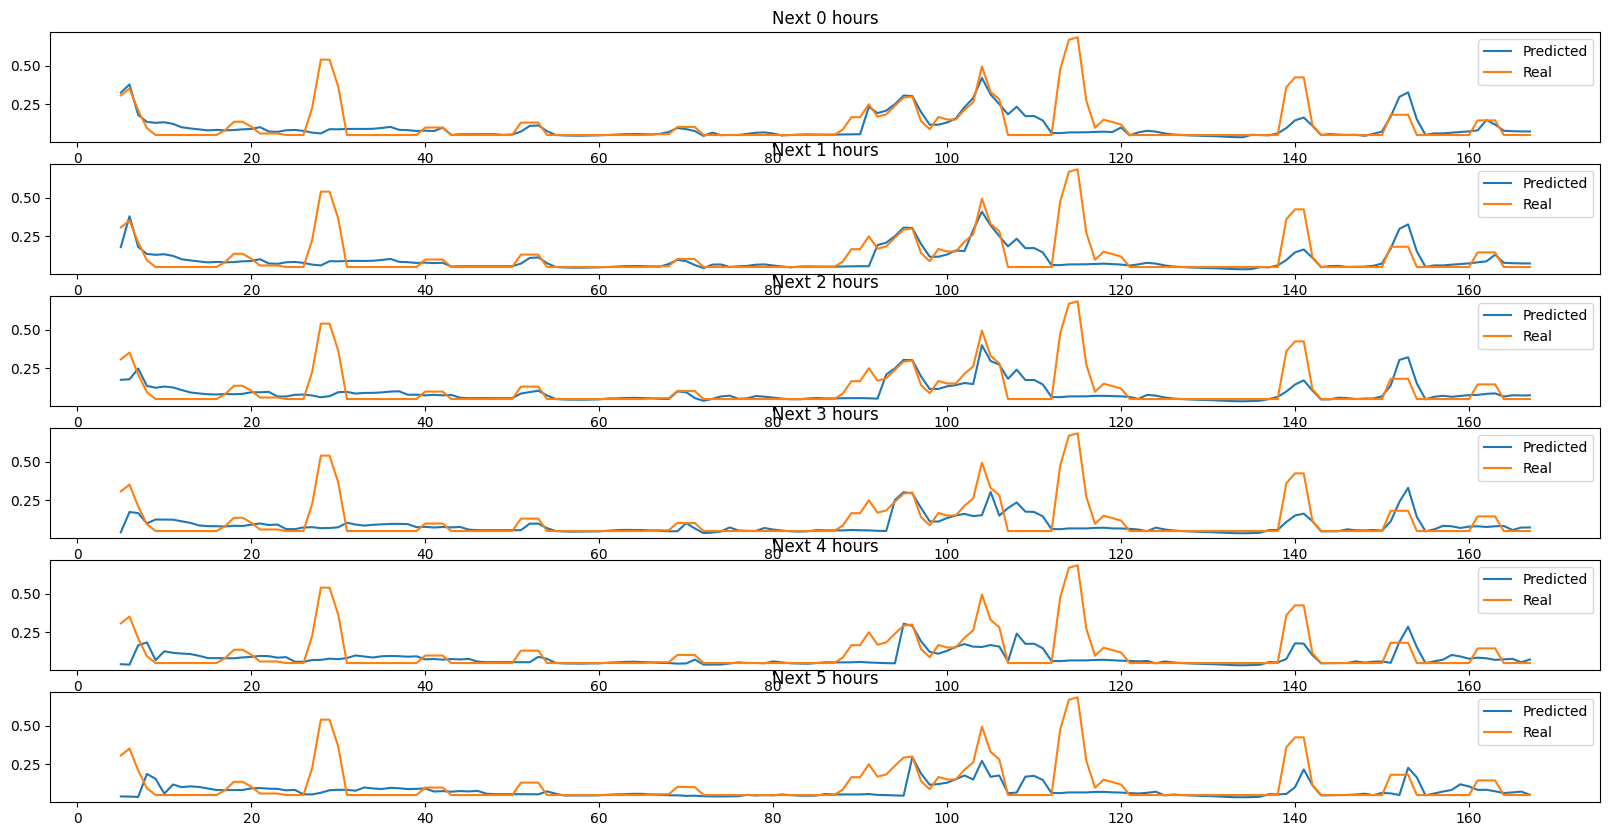

In [38]:

# Display the new DataFrame
import matplotlib.pyplot as plt
# create a 6 sub plots
ax, fig = plt.subplots(6,1, figsize=(20, 10))


for x in range(0, 6):
    fig[x].plot(shifted_df[x], label='Predicted')
    fig[x].plot(shifted_df['truth'], label='Real')
    integral_pred = np.trapz(shifted_df[x])
    integral_real = np.trapz(shifted_df['truth'])
    print(f"Integral predicted: {integral_pred}, Integral real: {integral_real}, Integral delta: {integral_pred-integral_real}")
    fig[x].legend()
    fig[x].set_title(f"Next {x} hours")

In [39]:
left_test = datetime(2024,1,1)
right_test = datetime(2024,3,1)

df_test_direct = forecast.dataHandler.get_data_for_prediction(left_test, right_test)

In [40]:
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt
# df_test,_ = dataHandler.get_data_for_training_model(left_time_interval=datetime(2024, 3, 1, 0, 0, 0, 0), right_time_interval=datetime(2024, 3, 16, 0, 0, 0, 0))
df_test_norm = df_test_direct.copy()


# df_train_norm.loc[:,predicted_column:] = scaler.fit_transform(df_train.loc[:,predicted_column:])
# df_test_norm.loc[:,predicted_column:] = scaler.transform(df_test.loc[:,predicted_column:])
df_test_norm[df_test_direct.columns] = forecast.scaler.transform(df_test_direct)

test_gen = forecast.mul_generator(dataframe = df_test_norm, 
                     target_names = predicted_columns, 
                     lookback = forecast.lookback,
                     delay = forecast.delay,
                     min_index = 0,
                     max_index = None,
                     step = 1,
                     shuffle = False,
                     batch_size = df_test_norm.shape[0])
(X, y_truth) = next(test_gen)
# X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))

y_pred = forecast.model.predict(X)

 1/44 [..............................] - ETA: 0s

44/44 [==============================] - 0s 8ms/step


1 12 11


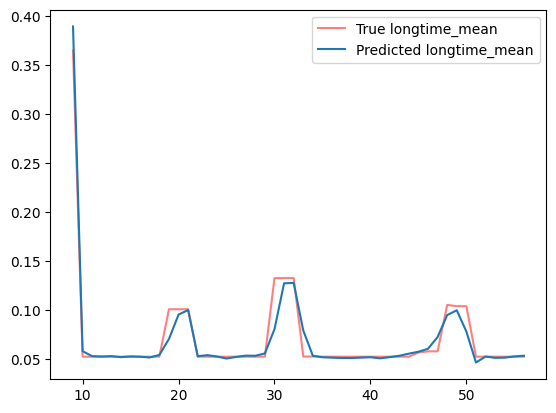

R2 =  0.2792614026487171
integral =  23.541236143292544
integral_truth =  126.73500215900343
integral_pred =  150.27623830229598


ValueError: too many values to unpack (expected 4)

In [46]:


num_targets = len(predicted_columns)
len_columns = len(df_test.columns)
num_features = len_columns - num_targets

print(num_targets, len_columns, num_features)

# np.expand_dims(y_truth,axis=1).shape
y_pred_inv = np.concatenate(
    (y_pred, np.zeros((y_pred.shape[0], num_features))), axis=1
)
y_pred_inv = forecast.scaler.inverse_transform(y_pred_inv)

y_truth_concat = np.concatenate(
    (y_truth, np.zeros((y_truth.shape[0], num_features))), axis=1
)
y_truth_concat = forecast.scaler.inverse_transform(y_truth_concat)

# create a dataframe from y_pred_inv and y_truth_concat
y_pred_inv_df = pd.DataFrame(y_pred_inv, columns=df_test.columns)
y_truth_concat_df = pd.DataFrame(y_truth_concat, columns=df_test.columns)

y_pred_inv_df['truth'] = y_truth_concat_df['longtime_mean']
y_pred_inv_df['longtime_mean'] = y_pred_inv_df['longtime_mean']

y_pred_inv_df = y_pred_inv_df.dropna()  


for i in range(num_targets):

    plt.figure()
    plt.plot(y_pred_inv_df['truth'][:48], label=f'True {predicted_columns[i]}', alpha=0.5, color='red')
    plt.plot(y_pred_inv_df['longtime_mean'][:48], label=f'Predicted {predicted_columns[i]}')
    plt.legend()
    plt.show()
    slope, intercept, r_value, p_value, std_err = stats.linregress(x=y_pred_inv_df['longtime_mean'],y=y_pred_inv_df['truth'])
    # mse = mean_squared_error(y_true=y_truth_curr, y_pred=y_pred_curr, squared=True)
    # rmse = mean_squared_error(y_true=y_truth_curr, y_pred=y_pred_curr, squared=False)


    print('R2 = ',r_value*r_value)
    # print('mse = ',mse)
    # print('rmse = ',rmse)
    #print integral of y_pred_curr - y_truth_curr
    print('integral = ',np.trapz(y_pred_inv_df['truth'] - y_pred_inv_df['longtime_mean']))
    print('integral_truth = ',np.trapz(y_pred_inv_df['longtime_mean']))
    print('integral_pred = ',np.trapz(y_pred_inv_df['truth']))


slope, intercept, r_value, p_value, std_err = stats.linregress(x=y_pred,y=y_truth)
mse = mean_squared_error(y_true=y_truth, y_pred=y_pred, squared=True)
rmse = mean_squared_error(y_true=y_truth, y_pred=y_pred, squared=False)


print('R2 = ',r_value*r_value)
print('mse = ',mse)
print('rmse = ',rmse)

In [ ]:

from pytz import utc
import pandas as pd
import numpy as np
from data_handler import DataHandler
from forecast import Forecast
from datetime import datetime, timedelta
start_of_data = datetime(2023, 11, 1)
end_of_data = datetime(2023, 12, 10)
end_of_training_data = datetime(2023, 12, 31, 0, 0, 0)
dataHandler = DataHandler(
    "localhost",
    "smart_home_zukalovi",
    "root",
    "root",
    "shelly1pm_84cca8b07eae",
    "shelly1pm_84cca8b07eae_power",
    "esphome_web_c771e8_tmp3",
    "esphome_web_c771e8_ntc_temperature_b_constant",
    "esphome_web_c771e8_ntc_temperature_b_constant_2",
    device_tracker_entity_id="klara_z_iphone",
    home_longitude=49.412897925874184,
home_latitude=16.514843458109933,
start_of_data=start_of_data,
)



In [ ]:
# df_train_norm to csv with header as colun name
df_train_norm.to_csv('df_train_norm.csv', header=True, index=False)

In [ ]:
# def r2_keras(y_true, y_pred):
#     """Coefficient of Determination 
#     """
#     SS_res =  K.sum(K.square( y_true - y_pred ))
#     SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
#     return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def r2_keras(y_true, y_pred):
    """Coefficient of Determination for multiple outputs"""
    SS_res = K.sum(K.square(y_true - y_pred), axis=0)
    SS_tot = K.sum(K.square(y_true - K.mean(y_true, axis=0)), axis=0)
    return K.mean(1 - SS_res / (SS_tot + K.epsilon()))

## Create LSTM model
- to increase the modeling speed, replace the LSTM model with CuDNNLSTM and train on a GPU
- can also use lightwieght GRU layers

## Fit the Model
- to increase the modeling speed, replace the LSTM model with CuDNNLSTM and train on a GPU

## Get model predictions on df_test
- get (X,y_truth) by calling train_gen using next
- set the batch_size

In [ ]:
model = load_model('lstm_model_mul_var.keras', custom_objects={'r2_keras': r2_keras})

In [ ]:
df_test_norm.shape

In [ ]:
# append a value to all rows in longtimemean column zeroes

test_gen = forecast.mul_generator(dataframe = df_test_norm, 
                      target_names = predicted_columns, 
                     lookback = lookback,
                     delay = delay,
                     min_index = 0,
                     max_index = None,
                     step = 1,
                     shuffle = False,
                     batch_size = df_test.shape[0])
(X, y_truth) = next(test_gen)
y_pred = model.predict(X)

num_targets = len(predicted_columns)
len_columns = len(df_test.columns)
num_features = len_columns - num_targets

# np.expand_dims(y_truth,axis=1).shape
y_pred_inv = np.concatenate(
    (y_pred, np.zeros((y_pred.shape[0], num_features))), axis=1
)
y_pred_inv = scaler.inverse_transform(y_pred_inv)

y_truth = np.concatenate(
    (y_truth, np.zeros((y_truth.shape[0], num_features))), axis=1
)
y_truth = scaler.inverse_transform(y_truth)


In [ ]:
y_pred_abs = np.abs(y_pred_inv) - 0.2
for i in range(num_targets):
    plt.figure()
    plt.plot(y_truth[:, i], label=f'True {predicted_columns[i]}')
    plt.plot(y_pred_abs[:, i], label=f'Predicted {predicted_columns[i]}')
    plt.legend()
    plt.show()
    y_pred_curr = y_pred_abs[:48, i]
    y_truth_curr = y_truth[:48, i]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x=y_pred_curr,y=y_truth_curr)
    mse = mean_squared_error(y_true=y_truth_curr, y_pred=y_pred_curr, squared=True)
    rmse = mean_squared_error(y_true=y_truth_curr, y_pred=y_pred_curr, squared=False)


    print('R2 = ',r_value*r_value)
    print('mse = ',mse)
    print('rmse = ',rmse)
    #print integral of y_pred_curr - y_truth_curr
    print('integral = ',np.trapz(y_pred_curr - y_truth_curr))
    

In [ ]:
from datetime import timedelta, datetime
import pandas as pd


In [ ]:
def add_empty_row(df, date_time):
    new_row_df = pd.DataFrame(
        columns=df.columns,
        data=[
            [
                0,
                0,
                0,
                0,
                0,
                0,
                np.sin(2 * np.pi * date_time.weekday() / 7),
                np.cos(2 * np.pi * date_time.weekday() / 7),
                np.sin(2 * np.pi * date_time.hour / 24),
                np.cos(2 * np.pi * date_time.hour / 24),
                np.sin(2 * np.pi * date_time.minute / 60),
                np.cos(2 * np.pi * date_time.minute / 60),
            ]
        ],
    )
    df = pd.concat([df, new_row_df], ignore_index=True)
    df = df.reset_index(drop=True)
    
    return df

def get_forecast_next_steps(left_time_interval, right_time_interval):
    # Define the indices for the different predictions and truths

    num_targets = len(predicted_columns)
    len_columns = len(df_test.columns)


    forecast_future = pd.DataFrame()

    df_all = dataHandler.get_data_for_prediction(
        left_time_interval=left_time_interval,
        right_time_interval=right_time_interval,
        predicted_columns=predicted_columns,
    )
    df_all = df_all.dropna()
    df_all = df_all.reset_index(drop=True)
    forecast_future = pd.DataFrame()

    current_forecast_begin_date = right_time_interval + timedelta(hours=0.5)
    
    df_all = add_empty_row(df_all, current_forecast_begin_date)
    
    current_forecast_begin_date += timedelta(hours=0.5)

    # prediction for next 6 hours
    for i in range(0, 12):
        df_all = add_empty_row(df_all, current_forecast_begin_date)
        current_forecast_begin_date += timedelta(hours=0.5)

        df_predict_norm = df_all.copy()

        df_predict_norm[df_all.columns] = scaler.transform(df_all)
        # create predict df with values
        predict_gen = mul_generator(
            dataframe=df_predict_norm,
            target_names=predicted_columns,
            lookback=lookback,
            delay=delay,
            min_index=0,
            max_index=None,
            step=1,
            shuffle=False,
            batch_size=df_predict_norm.shape[0],
        )

        (X, y_truth) = next(predict_gen)

        y_pred = model.predict(X, verbose=0)
        # np.expand_dims(y_truth,axis=1).shape
        y_pred_inv = np.concatenate(
            (y_pred, np.zeros((y_pred.shape[0], len_columns-num_targets))), axis=1
        )
        y_pred_inv = scaler.inverse_transform(y_pred_inv)
        # get last predicted value
        y_pred_inv = y_pred_inv[-1, :]

        # append y_pred_inv to df_all
        df_all.iloc[-2,:num_targets] = y_pred_inv[:num_targets]
        # drop first row
        df_all = df_all[1:]

        forecast_future = pd.concat(
            [
                forecast_future,
                df_all.iloc[-2][:num_targets],
            ],
            axis=0,
        )
        forecast_future = forecast_future.reset_index(drop=True)
        

    return forecast_future, df_all

# last 48 values

In [ ]:

one_week_prediction = []
number_of_30_minutes = 14*24*2
end_train = datetime(2023,12,29, 0, 0, 0)
start_of_data_loader_for_forecast = end_train
end_of_data_loader_for_forecast = end_train + timedelta(hours=48)


for i in range(0, number_of_30_minutes):
    next_steps, _ = get_forecast_next_steps(left_time_interval=start_of_data_loader_for_forecast, right_time_interval=end_of_data_loader_for_forecast)
    one_week_prediction.append(next_steps)
    start_of_data_loader_for_forecast += timedelta(minutes=30)
    end_of_data_loader_for_forecast += timedelta(minutes=30)

In [ ]:
df_truth = dataHandler.get_data_for_prediction(left_time_interval=end_train+timedelta(hours=48), right_time_interval=end_train+timedelta(hours=48)+timedelta(minutes=30*number_of_30_minutes))

In [ ]:
list_df = []
for df in one_week_prediction:
    df_reshaped = (pd.DataFrame(np.reshape(df.values, (-1, 6)))).T
    df_reshaped['prediction'] = [i for i in predicted_columns]

    # transpose 
    list_df.append(df_reshaped)
merged_df = pd.concat(list_df, ignore_index=True)
merged_df['DataFrame_Order'] = [i for i in range(len(list_df)) for _ in range(6)]

    


In [ ]:
longtime_mean = merged_df[merged_df['prediction'] == 'longtime_mean']
distance_from_home = merged_df[merged_df['prediction'] == 'distance_from_home']
speed_towards_home = merged_df[merged_df['prediction'] == 'speed_towards_home']
count = merged_df[merged_df['prediction'] == 'count']
heading_to_home_sin = merged_df[merged_df['prediction'] == 'heading_to_home_sin']
heading_to_home_cos = merged_df[merged_df['prediction'] == 'heading_to_home_cos']




In [ ]:
merged_df

In [ ]:
# shift the columns by -i
shifted_df = merged_df.copy()
for j in predicted_columns:
    for i in range(0,12):
        shifted_df.loc[shifted_df['prediction'] == j, i] = shifted_df.loc[shifted_df['prediction'] == j, i].shift(-i)
        


In [ ]:
#keep only columns from predicted columns
data_truth = df_truth[predicted_columns]

In [ ]:
result_df = shifted_df.copy()
result_df['truth'] = 0  
for prediction_column in predicted_columns:

    for i in range(0,672):
        result_df.loc[(result_df['prediction'] == prediction_column) & (result_df['DataFrame_Order'] == i), 'truth' ] = data_truth.loc[i, prediction_column]

In [ ]:
result_df = result_df.dropna()

In [ ]:
for predicted_column in predicted_columns:
    number_of_steps = 1
    #create a list of collors from 0 to 12 based on color
    colors = plt.cm.viridis(np.linspace(0, 1, number_of_steps))
    for i in range(0, number_of_steps):
        plt.plot(result_df.loc[result_df['prediction']==predicted_column,i][:], label=f'predicted_{predicted_column}_{i}', color=colors[i], alpha=0.2)
    # i =0
    # plt.plot(df_shift[i], label=f'{i}_step_ahead')
    plt.plot(result_df.loc[result_df['prediction'] == predicted_column,'truth'][:], label='truth')
    plt.legend()   
    plt.show()

### Need to remove normalization
- since we preformed normlization transform on 7 cols of dataframe, we need to add dummy colums to preds

### Get R2 for this prediction

In [ ]:
print(y_truth.shape)

In [ ]:
print(y_pred.shape)

In [ ]:
#plot y_truth and y_pred
plt.plot(y_truth[0], color = 'red', label = 'Real data')

plt.plot(y_pred)


In [ ]:

plt.plot(y_truth, color = 'red', linestyle='dotted')
plt.plot(y_pred, color = 'blue', linestyle='dotted')
# change x ticks to dates
print(np.arange(0, df_test.shape[0], step=24))
# create list of dates by 1 hour from 2023-11-01 00:00:00 to 2023-11-30 23:00:00
start = pd.to_datetime('2023-12-16 19:00:00')
end = start + pd.Timedelta(hours=df_test.shape[0])
dates = pd.date_range(start, end, freq='1H')

# transform dates to format MM-DD HH
dates = dates.strftime('%Y-%m-%d')
# set xticks to dates
plt.xticks(np.arange(0, df_test.shape[0], step=24), dates[np.arange(0, df_test.shape[0], step=24)], rotation=45)

#add legend
plt.legend(['skutečnost','predikce'])

# add x and y label
plt.xlabel('Datum')
plt.ylabel('Spotřeba tepla [kJ]')


plt.show()

## Let's try the evaluate_generator in keras

In [ ]:
(_,r2) = model.evaluate_generator(generator=test_gen,steps=1,workers=1)
print('R2 = ',r2)
